<a href="https://colab.research.google.com/github/Kenrich005/ISB_Datathon_23/blob/main/Datathon_ISB_2023_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Business Objective

Develop a fraud analytics model that helps us (Kaspersky) detect fraud from good and normal user activity and identify precursors to the events

Process followed:


1.   Data cleaning - eliminating features that are redundant
2.   Feature engineering - creating new columns based on existing that would add depth to the outcome
3. Clustering - basic clustering to determine which transactions are different than others
4. Cluster Analysis - understanding why those clusters were formed, what makes them a cluster, cluster characteristics
5. Data Engineering - transposing the data such that the fraud event becomes the target variable, and all other becomes features for the same



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Dataset_Datathon_Fraud_Detection_28122022.csv',encoding= 'unicode_escape')
df.shape

(10969, 21)

In [3]:
df.head()

,customer_id,event_dttm_Deli,event_type_nm,client_defined_event_type_nm,event_desc,operaton_amt_100 (rupees),active phone call,remote desktop protokol,emulator,f,...,os,device_model,screensize,agentconnectiontype,screen_hash,device for user,reciever,password change,fast change of ip,ip not equal to previous
0,customer_id_0,2022-10-01 10:51:36,CHANGE_PASSWORD,RENEW,Login password recovery,0.0,NaN,NaN,NaN,St Petersburg,...,NaN,NaN,NaN,NaN,287067538.0,new,old,NaN,NaN,IP differes
1,customer_id_0,2022-10-01 11:15:21,SESSION_SIGNIN,SESSION_SIGNIN,Login,0.0,NaN,NaN,NaN,St Petersburg,...,NaN,NaN,NaN,NaN,287067538.0,new,old,happened on the same day,NaN,IP differes
2,customer_id_0,2022-10-01 11:31:55,SESSION_SIGNIN,SESSION_SIGNIN,Login,0.0,NaN,NaN,NaN,St Petersburg,...,NaN,NaN,NaN,NaN,-205759950.0,new,old,happened on the same day,NaN,IP differes
3,customer_id_0,2022-10-01 11:45:42,SESSION_SIGNIN,SESSION_SIGNIN,Login,0.0,NaN,NaN,NaN,St Petersburg,...,NaN,NaN,NaN,NaN,287067538.0,new,old,happened on the same day,NaN,IP differes
4,customer_id_0,2022-10-03 10:28:24,DEPOSIT,100_BKO,Payment order,116820.0,1.0,False,NaN,NaN,...,iOS,iPhone,375x812,wifi,NaN,NaN,old,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10969 entries, 0 to 10968
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   10969 non-null  object 
 1   event_dttm_Deli               10969 non-null  object 
 2   event_type_nm                 10969 non-null  object 
 3   client_defined_event_type_nm  9554 non-null   object 
 4   event_desc                    10800 non-null  object 
 5   operaton_amt_100 (rupees)     10969 non-null  float64
 6   active phone call             3778 non-null   float64
 7   remote desktop protokol       3786 non-null   object 
 8   emulator                      2923 non-null   float64
 9   f                             4666 non-null   object 
 10  device_id                     3786 non-null   object 
 11  os                            3786 non-null   object 
 12  device_model                  3786 non-null   object 
 13  s

## Understanding the data
We are given with user activity history. 
Each activity is defined by 20 features. 
We see that considerable amount of data is null. 
Most importantly, we notice that we do not have a target variable. 
i.e. we do not know which activity is fraud.  

So, our foremost task then becomes to identify which transaction should be considered fraud, and have a strong backing to support it.  
Because, if our understanding of fraud transaction is incorrect, the model built therefore would also be incorrect.   
  
Let us understand each parameter one at a time

### **customer_id**

In [5]:
# Number of unique customer_id
df.customer_id.nunique()

200

In [6]:
# Number of transaction done by each customer
df.customer_id.value_counts()

customer_id_113    1430
customer_id_168    1002
customer_id_178     694
customer_id_196     219
customer_id_129     218
                   ... 
customer_id_156       4
customer_id_119       4
customer_id_137       4
customer_id_24        3
customer_id_169       3
Name: customer_id, Length: 200, dtype: int64

In [ ]:
# Too huge disparity!!! (Red Flag)
# Why some customers have just 3 transactions, while some have over 1000

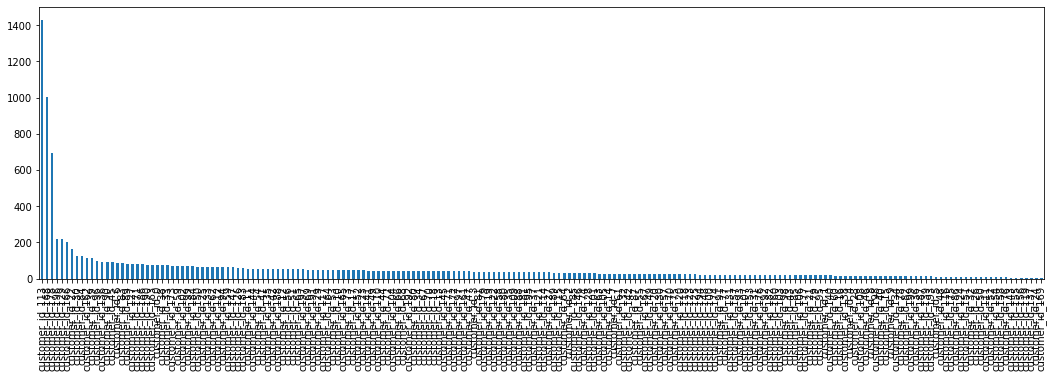

In [14]:
plt.figure(figsize=(18,5))
df.customer_id.value_counts().plot(kind='bar');

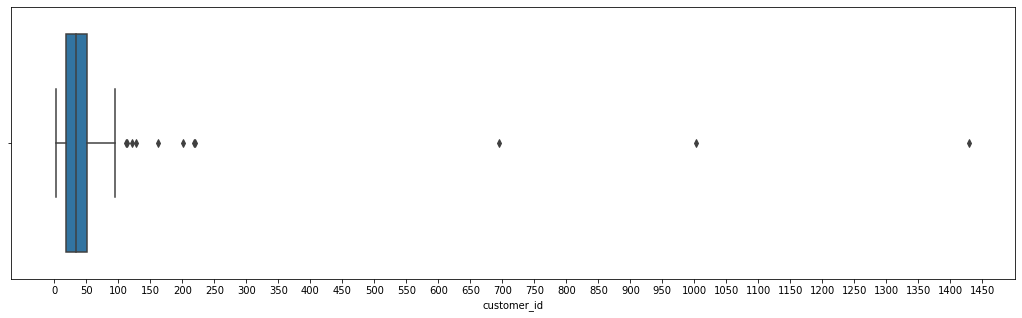

In [19]:
plt.figure(figsize=(18,5))
sns.boxplot(x=df.customer_id.value_counts())
plt.xticks(np.arange(0,1500,50));

Upon further examination, we see that only 3 customers have more than 600 events. About 75% customers have just 50 events.  
We sample one of the customers with low events to see if there is any story there.

In [ ]:
df[df.customer_id=="customer_id_119"]

,customer_id,event_dttm_Deli,event_type_nm,client_defined_event_type_nm,event_desc,operaton_amt_100 (rupees),active phone call,remote desktop protokol,emulator,f,...,os,device_model,screensize,agentconnectiontype,screen_hash,device for user,reciever,password change,fast change of ip,ip not equal to previous
5992,customer_id_119,2022-10-18 19:26:21,SESSION_SIGNIN,NaN,Login,0.00,0.0,False,0.0,Surat,...,Android,Xiaomi M2003J15SC,1080x2110,NaN,NaN,old,old,NaN,NaN,IP differes
5993,customer_id_119,2022-10-19 12:53:32,PAYMENT,POS_PURCHASE,Purchase,177.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,old,NaN,NaN,NaN
5994,customer_id_119,2022-10-19 15:29:13,PAYMENT,POS_PURCHASE,Purchase,200.60,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,old,NaN,NaN,NaN
5995,customer_id_119,2022-10-20 16:18:08,PAYMENT,POS_PURCHASE,Purchase,376.42,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,old,NaN,NaN,NaN


### **event_dttm_Deli**

In [27]:
# Number of unique event_dttm_Deli
df.event_dttm_Deli.nunique()

10837

In [28]:
# Converting to datetime format
df.event_dttm_Deli = pd.to_datetime(df.event_dttm_Deli)

# Start Datetime
min(df.event_dttm_Deli)

Timestamp('2022-09-22 17:43:37')

In [29]:
# End Datetime
max(df.event_dttm_Deli)

Timestamp('2022-11-23 19:53:06')

In [30]:
# Datetime Range


max(df.event_dttm_Deli) - min(df.event_dttm_Deli)

Timedelta('62 days 02:09:29')

In [31]:
df['weekday'] = df['event_dttm_Deli'].apply(lambda x: x.weekday())
df['weekday'].value_counts()

5    1759
0    1754
2    1592
3    1570
1    1538
4    1514
6    1242
Name: weekday, dtype: int64

In [32]:
df['day_of_week'] = df['event_dttm_Deli'].dt.day_name()
df['day_of_week'].value_counts()

Saturday     1759
Monday       1754
Wednesday    1592
Thursday     1570
Tuesday      1538
Friday       1514
Sunday       1242
Name: day_of_week, dtype: int64

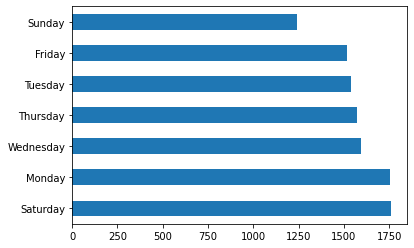

In [35]:
df.day_of_week.value_counts().plot(kind='barh');

Monday and Saturday have more events than other days, Sunday being the least.  
Since we don't have the target variable yet, we are unable to see the significance of this feature.

### **event_type_nm**

In [36]:
# Number of unique event_type_nm
df.event_type_nm.nunique()

15

In [37]:
df.event_type_nm.value_counts()

PAYMENT                  6387
SESSION_SIGNIN           2630
CLIENT_DEFINED            373
WITHDRAW                  336
DEPOSIT                   332
CHANGE_PASSWORD           269
CHECK                     207
CHANGE_ALERT_SETTINGS     149
VIEW_STATEMENT            100
REQUEST_CREDIT             70
CARD_PIN_CHANGE            53
REQUEST_NEW_CARD           24
USER_DETAILS               19
UPDATE_USER                19
ADD_PAYEE                   1
Name: event_type_nm, dtype: int64

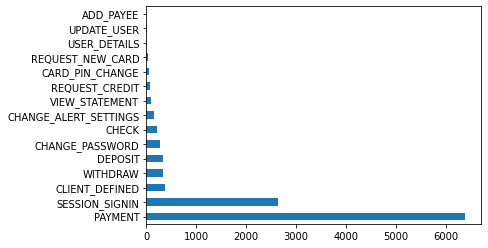

In [38]:
df.event_type_nm.value_counts().plot(kind='barh');

Payment and Session Signin are the most occuring events. We want to focus on these two events we want to identify fraudulent payments; suspicious session_signin becomes the precursor for the fraud.